In [20]:
# import de la base de données excel
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('sci.xlsx')

In [ ]:
# Suppression des variables illégales
#var_illegales = ['CODPAY_NAISSANCE', 'CODPAY_NATIONALITE','CODSEXPRS','CODCMNIEE'] # CODPAY_RESIDENCE
#df.drop(columns=var_illegales, inplace=True)

### Vérifications préliminaires

In [9]:
# Vérification des doublons par ligne dans la base de données
print(df.duplicated().sum())

0


In [ ]:
# Vérification des doublons par colonnes
all(df['CRTAD_AG_SOLDE_T']==df["CRTAE_AG_SLDEPA"])

False

In [ ]:
print(f"{all(df['DATCREENT'==df['DATCREPRSENT']])=}")
df.drop(columns=['DATCREPRSENT'],inplace=True)

all(df['DATCREENT'==df['DATCREPRSENT']])=True


In [10]:
var_redondantes = ['secteur_activite', 'secteur_activite_bis' ]
df.drop(columns=var_redondantes,inplace=True)

# I. Identification de la variable cible et analyse des variables explicatives

## I.1. La variable cible 

In [ ]:
cible = "DDefaut_NDB"
print("Initial type of target column")
print(df[[cible]].dtypes)

Initial type of target column
DDefaut_NDB    int64
dtype: object


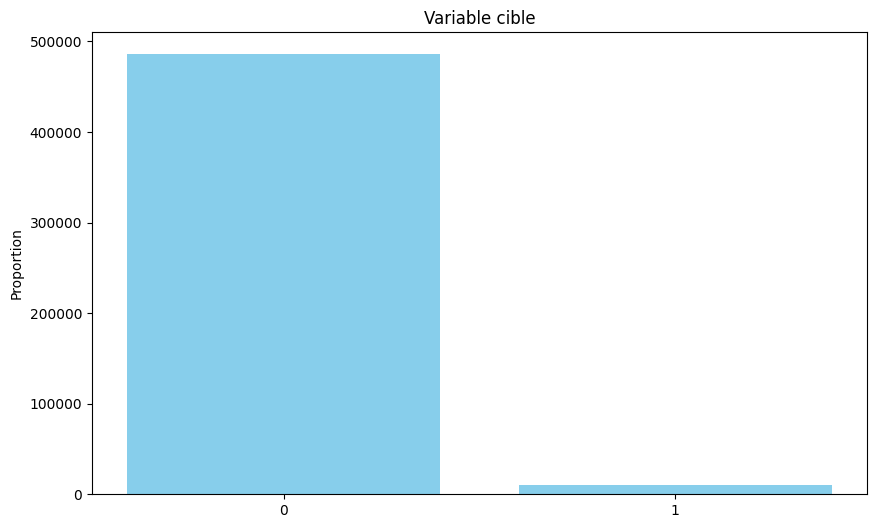

In [28]:

import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df[cible].value_counts().index.astype(str), df[cible].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [12]:
#Transformer le format de date :
print("Nombre de dates : ",df[['datdelhis']].nunique())
print("Format de date initial: ", df[['datdelhis']].dtypes)


df['datdelhis'] = pd.to_datetime(df['datdelhis'], format = '%Y%m')
print("Format de date final: ", df[['datdelhis']].dtypes)


Nombre de dates :  datdelhis    6
dtype: int64
Format de date initial:  datdelhis    int64
dtype: object
Format de date final:  datdelhis    datetime64[ns]
dtype: object


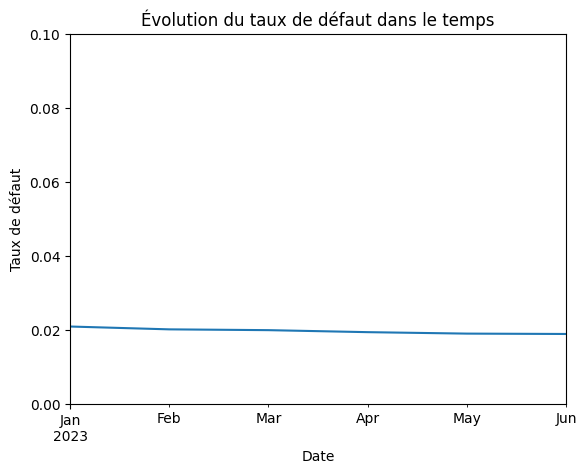

In [13]:
# Evolution de la variable cible dans le temps
import matplotlib.pyplot as plt

taux_cible = df.groupby(df['datdelhis'].dt.to_period('M'))['DDefaut_NDB'].mean() # ou sum()

# Tracer le taux de la variable cible au fil du temps
taux_cible.plot(title='Évolution du taux de défaut dans le temps')
plt.xlabel('Date')
plt.ylabel('Taux de défaut')
plt.ylim(0,0.1)
plt.show()

## I.2. Construction de la base d'échantillon

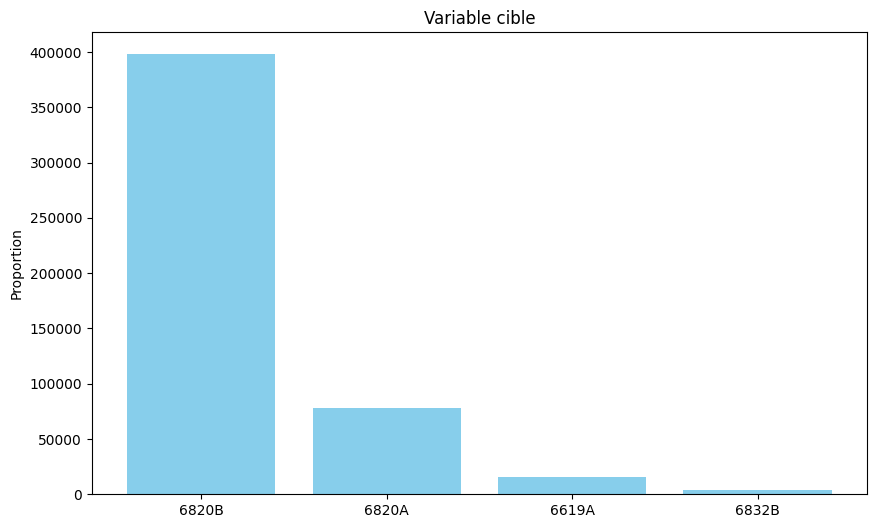

In [29]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df['CODNAF2'].value_counts().index.astype(str), df['CODNAF2'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

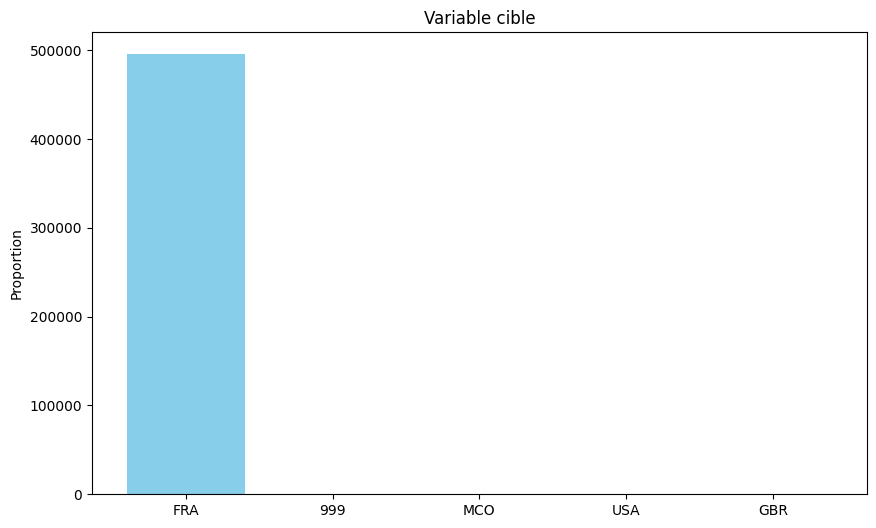

In [30]:
### Attention au biais lié au pays de résidence
### Impossibilité de stratifier par pays de résidence
### Soit on travaille qu'avec la France, soit on a conscience du biais régionale.

plt.figure(figsize=(10, 6))
plt.bar(df['CODPAY_RESIDENCE'].value_counts().index.astype(str), df['CODPAY_RESIDENCE'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [7]:
df['CODPAY_RESIDENCE'].value_counts(normalize=True)

CODPAY_RESIDENCE
FRA    0.999655
999    0.000161
MCO    0.000159
USA    0.000012
GBR    0.000012
Name: proportion, dtype: float64

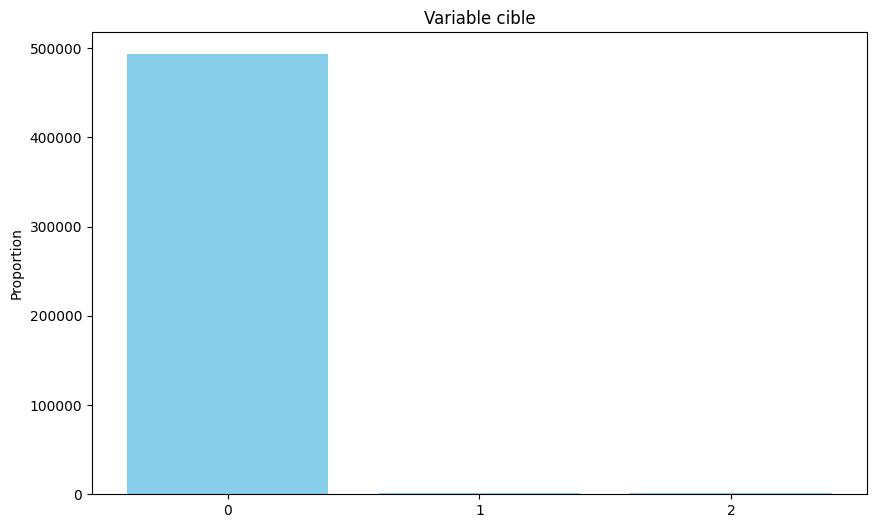

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(df['CODSEXPRS'].value_counts().index.astype(str), df['CODSEXPRS'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [ ]:
# Biais lié au sexe et au type de client (personne morale, physique)
df['CODSEXPRS'].value_counts(normalize=True)
df['IND_PER_PM'].value_counts(normalize=True)


IND_PER_PM
PM    0.994987
PP    0.005013
Name: proportion, dtype: float64

In [ ]:
## crée une variable qui prend en entrée une variable qualitative 
# si la variable ne prend pratiquement qu'une modalité (à partir d'un seuil qu'on se fixe)
# on ne l'utilise pas dans le modèle

In [ ]:
## Creation des echantillons train et test 
from sklearn.model_selection import train_test_split

# Retrait des mauvaises variables de prédictions (variables ne prenant pratiquement qu'une seule modalité)
X = df.drop(columns = [cible,'id_client','CODSEXPRS','IND_PER_PM','CODPAY_RESIDENCE'])
y = df[cible]
X['stratify_col'] = df[cible].astype(str) + '_' + df['datdelhis'].astype(str) + '_' +  df['CODNAF2'].astype(str) 

# Split train-test stratifié en utilisant la colonne combinée
X_train, X_test, y_train, y_test = train_test_split(
    X,  y,
    stratify=X['stratify_col'],  # La nouvelle colonne pour la stratification
    test_size=0.2,                # La proportion de l'ensemble de test
    random_state=42               # La graine pour la reproductibilité
)


In [18]:
# Suppression de la colonne de stratification car non utile pour la suite
X_train = X_train.drop(['stratify_col'], axis=1)
X_test = X_test.drop(['stratify_col'], axis=1)

In [ ]:
df.info()
# 64 colonnes au total, 56 colonnes de type float ou int, 
# 6 colonnes de type object (supposées qualitatives), 
# 2 colonnes de types date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495514 entries, 0 to 495513
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   DDefaut_NDB                  495514 non-null  int64         
 1   datdelhis                    495514 non-null  datetime64[ns]
 2   AGEPRS                       495514 non-null  int64         
 3   ANCIENNETE                   495514 non-null  int64         
 4   CODETAJUR                    495514 non-null  int64         
 5   CODITDBDF_PRO                495514 non-null  int64         
 6   CODNAF2                      495514 non-null  object        
 7   CODTYPPRS                    495514 non-null  int64         
 8   CRTAD_AG_MVTAFF_IND_0010     495514 non-null  int64         
 9   CRTAD_AG_NBECR_A             495514 non-null  int64         
 10  CRTAD_AG_NBECR_B             495514 non-null  int64         
 11  CRTAD_AG_NBJDE_BA         

In [ ]:
#### ANALYSE DE LA REPRESENTATITVITÉ DES VARIABLES

## I.3. Création de nouveaux indicateurs et préselection de variables 

In [ ]:
df['SECTNAF'] = df['CODNAF2'].str[-1]
df["ANCENT"]= df['datdelhis'].dt.month - df['DATCREENT'].dt.month

In [33]:
df['DATCREENT'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 495514 entries, 0 to 495513
Series name: DATCREENT
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
float_columns = X_train.select_dtypes(include=['float64','int64']).columns.tolist()

print(len(object_columns)) #Assuming object variables are categorical and float/int variables are numerical
print(len(float_columns))

In [ ]:
X_train.info()